In [1]:
using Integrals
using SpecialFunctions
using Base.Threads
using Glob
using DataFrames
using CSV
using CairoMakie
using LaTeXStrings
using Polynomials
using Statistics

CairoMakie.activate!(inline=true)

┌ Warning: Error requiring `MakieCore` from `Polynomials`
│   exception = (LoadError("/home/davidgoh/.julia/packages/Polynomials/6i39P/ext/PolynomialsMakieCoreExt.jl", 1, ArgumentError("Package Polynomials does not have MakieCore in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have Polynomials checked out for development and have\n  added MakieCore as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with Polynomials")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00002aaad66c8a7e, Ptr{Nothing} @0x00002aaad66c8ca6, Ptr{Nothing} @0x00002aaaabcacdbd, Ptr{Nothing} @0x00002aaaabceae48, Ptr{Nothing} @0x00002aaaabcecf5a, Ptr{Nothing} @0x00002aaaabcec607, Ptr{Nothing} @0x00002aaaabcec7e8, Ptr{Nothing} @0x00002aaaabcedc2a, Ptr{Nothing} @0x00002aaabe209d11, Ptr{Nothing} 

In [2]:
custom_theme = Theme(
    fontsize = 8,
    linewidth = 1.5,
    fonts = (regular = "Helvetica",),
    Axis = (
        spinewidth = 1,
        xgridvisible = false,
        ygridvisible = false,
        topspinevisible = false,
        rightspinevisible = false,
        xtickwidth = 1,
        xticksize = 3,
        ytickwidth = 1,
        yticksize = 3,
    ),
    Colorbar = (
        spinewidth = 1,
        tickwidth = 1,
        ticksize = 2,
    ),
    Figure = (
        dpi = 100,
    )
)

set_theme!(custom_theme)

In [3]:
function mrna(r,α,kp)
    function f(u,p)
        ϕ₁ = u[1]; r₁ = u[2]
        ϕ = p[1]; r = p[2]; σ = p[3]; d = p[4]; α = p[5]
        return r₁*besselk(0,α*sqrt(r^2+r₁^2-2*r*r₁*(cos(ϕ)*cos(ϕ₁)+sin(ϕ)*sin(ϕ₁))))*exp(-(r₁^2-2*r₁*cos(ϕ₁)*d+d^2)/(2*σ^2))
    end
    d = 0; ϕ = 0; σ = 2.5; χ = -0.1; Mc = Mm = 1; cm = 3.5; cp = 4.5
    domain = ([0,0], [2*π,Inf]) # (lb, ub)
    p = (ϕ, r, σ, d, α)
    prob = IntegralProblem(f, domain, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-6, abstol = 1e-6)
    m = sol.u * kp * cm / (2*π*Mm)
    return m
end

mrna (generic function with 1 method)

In [4]:
rnadf = CSV.read("RNA.csv",DataFrame,header=false);
rename!(rnadf, Dict(names(rnadf)[1] => :r, names(rnadf)[2] => :m));

In [5]:
function getkp(α1,α2,kp)
    kp * mrna(0, α1, 1)/mrna(0, α2, 1)
end

getkp (generic function with 1 method)

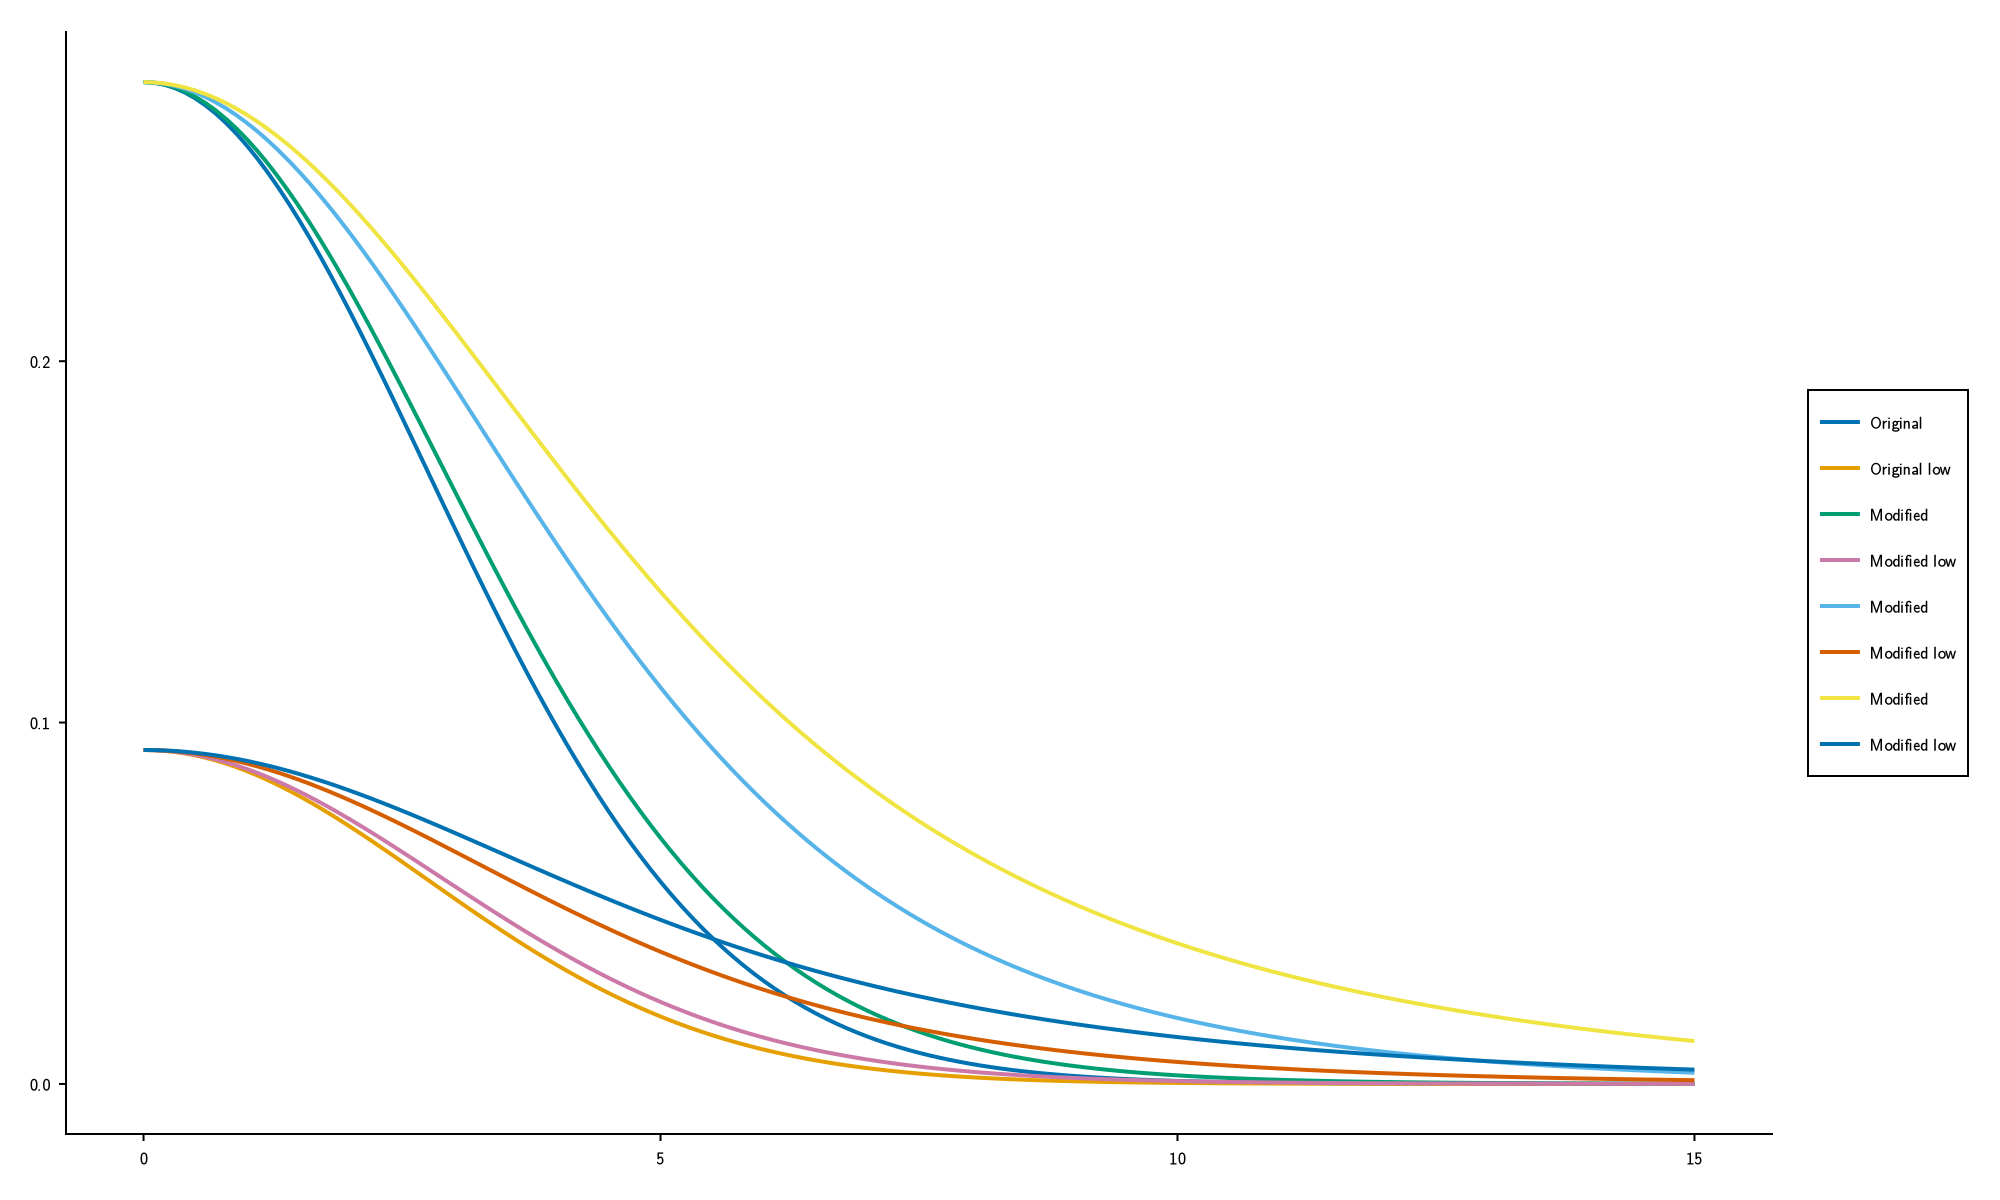

In [8]:
fig = Figure(size = (1000, 600))
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
# scatter!(ax1, rnadf[!,:r], rnadf[!,:m],color="red",markersize=4,label="Simulation")
α = 1
lines!(ax1, x, mrna.(x, α, 0.1),label="Original")
lines!(ax1, x, mrna.(x, α, 0.1/3),label="Original low")
α = 1/sqrt(2)
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)),label="Modified")
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)/3),label="Modified low")
α = 1/sqrt(10)
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)),label="Modified")
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)/3),label="Modified low")
kd = 1/25
α = sqrt(kd/1)
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)),label="Modified")
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)/3),label="Modified low")

Legend(fig[1, 2], ax1) # kp/kd kp*alpha
fig

In [35]:
mrnaprofile = mrna.(x, α, 0.1)

151-element Vector{Float64}:
 0.2772417942496426
 0.2770599383715229
 0.2765151612564367
 0.2756096395561736
 0.27434705922827307
 0.27273243950367815
 0.27077230668268554
 0.26847447394220114
 0.2658479608222745
 0.26290322959895635
 ⋮
 1.1179929432207669e-5
 1.0076280609686811e-5
 9.082342596409863e-6
 8.188946825945764e-6
 7.385698511153847e-6
 6.661757036619062e-6
 6.008173084391358e-6
 5.4192177003409926e-6
 4.8875790082725605e-6

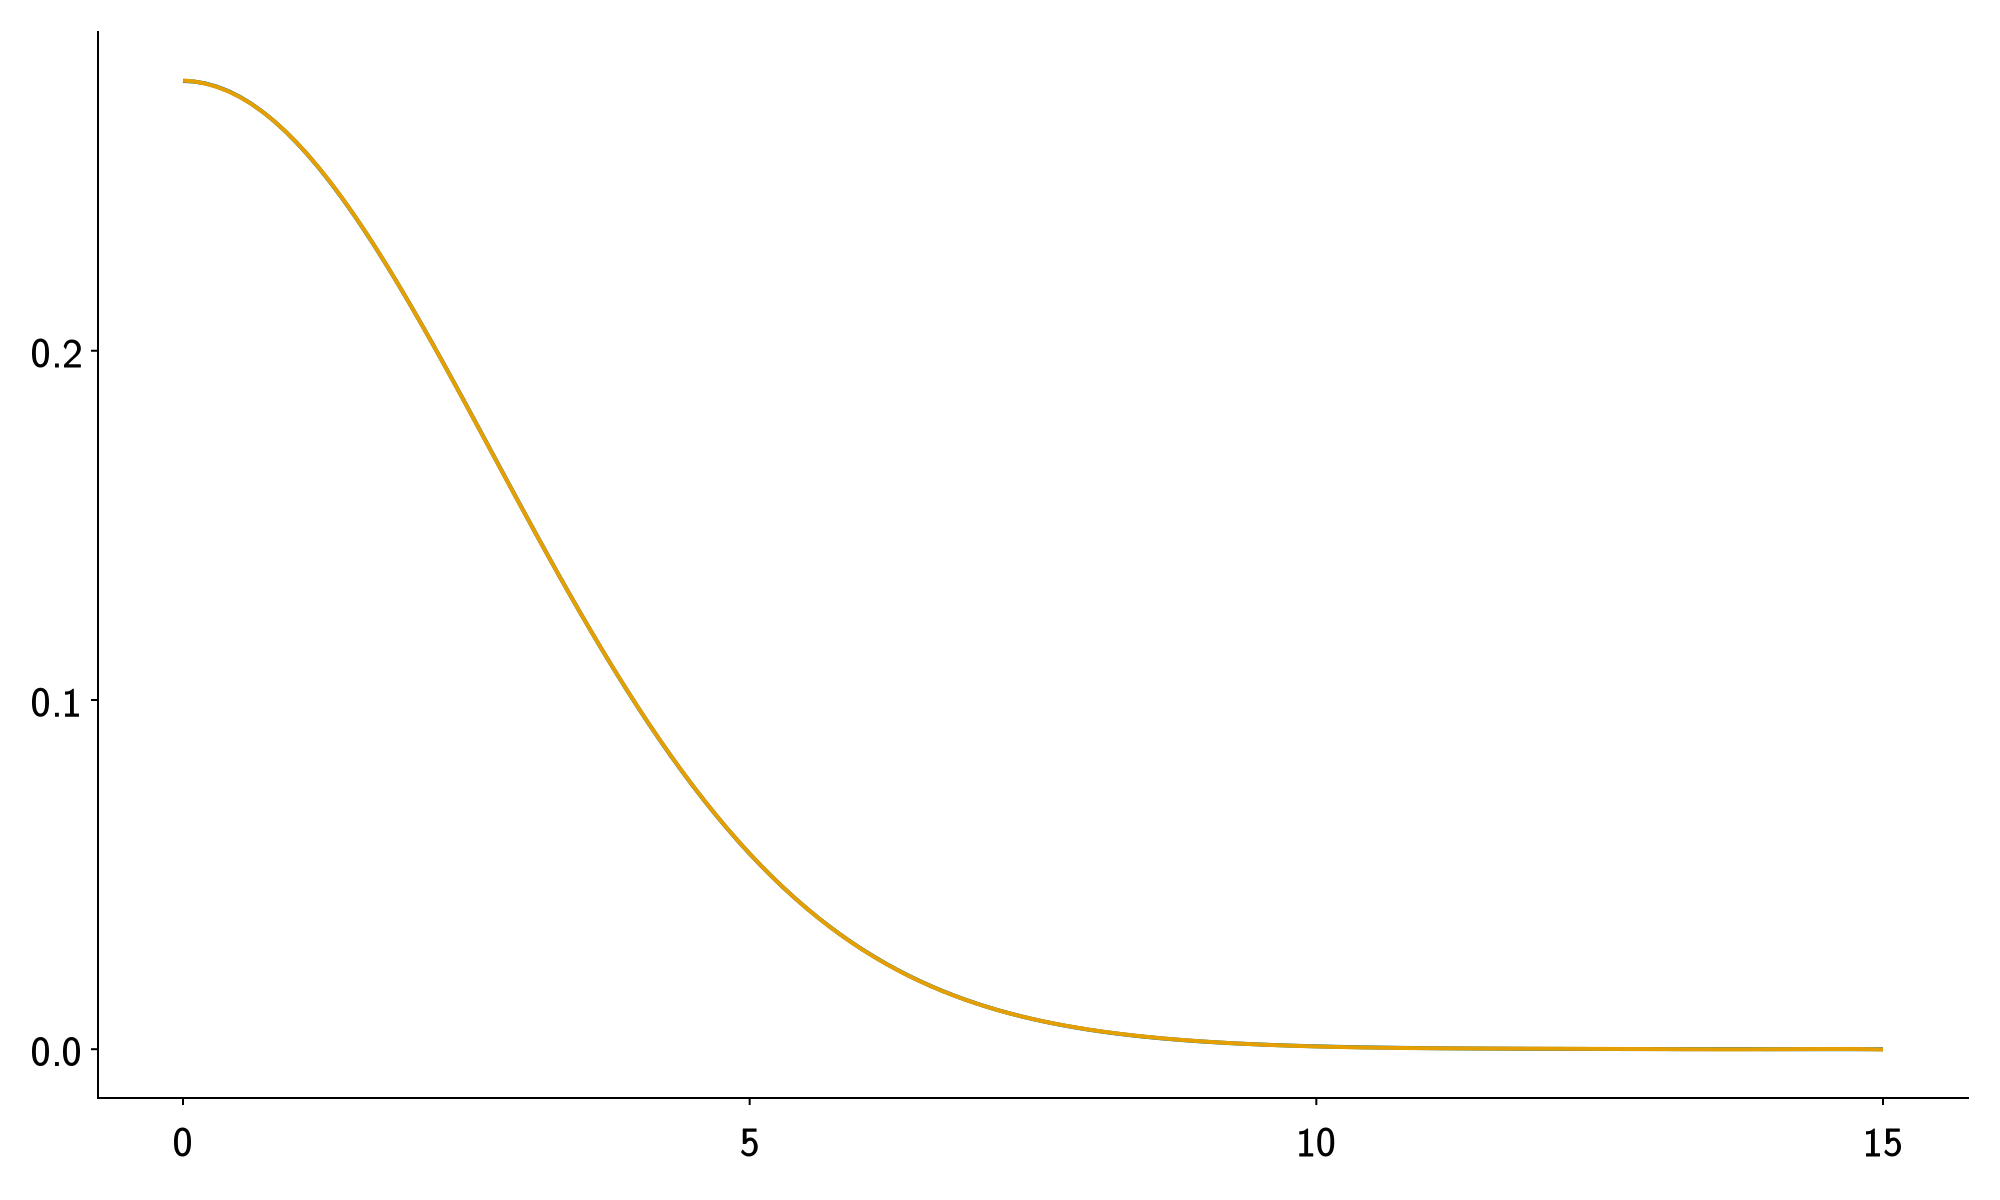

In [51]:
fig = Figure(size = (1000, 600))
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
# scatter!(ax1, rnadf[!,:r], rnadf[!,:m],color="red",markersize=4,label="Simulation")
α = 1
lines!(ax1, x, mrnaprofile,label="Original")
p = fit(x, mrnaprofile, 10)
lines!(ax1, x, p.(x), label="Polynomial")
fig

In [53]:
println(p)

0.277384 - 0.00156433*x - 0.0146816*x^2 - 0.00317079*x^3 + 0.00204666*x^4 - 0.000344679*x^5 + 2.58265e-5*x^6 - 5.86922e-7*x^7 - 3.73715e-8*x^8 + 2.6403e-9*x^9 - 4.8109e-11*x^10


In [106]:
maximum(mrna.(x, α, 0.1))

0.2772417942496426

In [73]:
function mirror1(x); [reverse(-x);x]end
function mirror2(x); [reverse(x);x]end

mirror2 (generic function with 1 method)

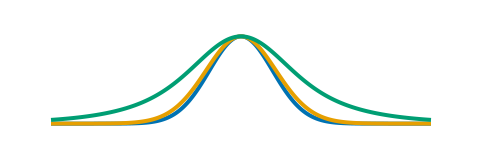

In [83]:
prl_col_size = 8.5 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size*pt_per_cm, prl_col_size*pt_per_cm*1/3),background_color=:transparent)
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
gaussian = exp.(-x .^2 ./(2 * σ^2)) .* original[1]
lines!(ax1, mirror1(x), mirror2(gaussian), label="Locus")
kd = 1/1
α = sqrt(kd/1)
original = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, mirror1(x), mirror2(original), label="Original")

kd = 1/25
α = sqrt(kd/1)
σ = 2.5
modified = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, mirror1(x), mirror2(modified), label="Modified")

hidespines!(ax1)
hidedecorations!(ax1)
save("./figures/rnaprofiles.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

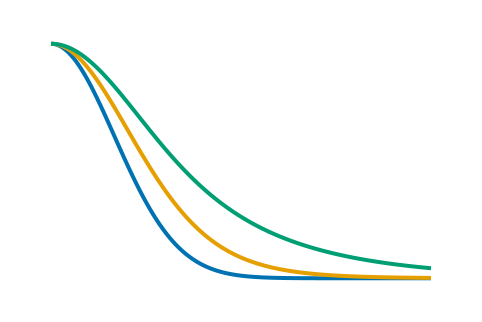

In [82]:
prl_col_size = 8.5 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size*pt_per_cm, prl_col_size*pt_per_cm*2/3),background_color=:transparent)
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
gaussian = exp.(-x .^2 ./(2 * σ^2)) .* original[1]
lines!(ax1, x, gaussian, label="Locus")
kd = 1/4
α = sqrt(kd/1)
original = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, x, original, label="Original")

kd = 1/25
α = sqrt(kd/1)
σ = 2.5
modified = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, x, modified, label="Modified")

hidespines!(ax1)
hidedecorations!(ax1)
save("./figures/rnaprofiles.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

In [20]:
getkp(1,α,0.1)

0.013779117859431972

In [6]:
getkp(1,α,0.1)

0.013779117859431972

In [7]:
kd = 1/25


0.04

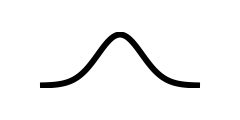

In [29]:
prl_col_size = 8.5 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size*pt_per_cm/2, prl_col_size*pt_per_cm*1/4),background_color=:transparent)
ax1 = Axis(fig[1, 1])
x = 0:0.1:10
m = mrna.(x,1,0.1)
lines!(ax1, [reverse(-x);x], [reverse(m);m],color="black")
hidespines!(ax1)
hidedecorations!(ax1)
save("./figures/rnaprofile.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

In [15]:
d = 5; R = 2.8; α =1; σ = 2.5; χ = -0.1; Mc = Mm = 1; kp = 0.1; cm = 3.5; cp = 4.5
function f(u,p)
    ϕ₁ = u[1]; r = u[2]; ϕ = u[3]
    R = p[1]; σ = p[2]; d = p[3]; α = p[4]
    return r*R*cos(ϕ)*besselk(0,α*sqrt(R^2+r^2-2*R*r*(cos(ϕ)*cos(ϕ₁)+sin(ϕ)*sin(ϕ₁))))*exp(-(r^2-2*r*cos(ϕ₁)*d+d^2)/(2*σ^2))
end
domain = ([0,0,0], [2*π,Inf,2*π]) # (lb, ub)
p = (R, σ, d, α)
prob = IntegralProblem(f, domain, p)
sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
velocity = (-χ*Mc*kp*cm)/((cp-cm)*π^2*Mm)*sol.u/R^2

0.006229033646333557

In [16]:
function introw(row)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    R = row["mean_radius"]; d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*3.52)/((cplus-3.52)*π^2*Mm)*sol.u/R^2
    return velocity
end

introw (generic function with 1 method)

In [17]:
function introwR(row,R)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*3.52)/((cplus-3.52)*π^2*Mm)*sol.u/R^2
    return velocity
end

introwR (generic function with 1 method)

In [18]:
Threads.@threads for stats in glob("20240224_FlowPhaseDiagramHighRes/*/flow_stats_100.csv")
    df = CSV.read(stats, DataFrame)
    df[!,"analytical_velocity"] = map(introw,eachrow(df))
    arr = df[!, "mean_radius"]
    avgR = sum(arr)/length(arr)
    df[!,"analytical_velocity_avgR"] = map(row -> introwR(row, avgR),eachrow(df))
    CSV.write(stats, df)
    print("Done. ")
end

Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. 

In [11]:
df = CSV.read("20240224_FlowPhaseDiagramHighRes/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.08_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0/flow_stats_100.csv", DataFrame)
arr = df[!, "mean_radius"]
avgR = sum(arr)/length(arr)

3.4767901406492037

In [13]:
df = CSV.read(glob("08_FreezeRNA/*/flow_stats_100.csv")[2],DataFrame)

Row,time,center_of_mass,eccentricity,variance_of_radius,mean_radius,rna_amount,velocity,smoothed_distance,smoothed_velocity,Mc,Mm,Chi,kp,kd,sigma,alpha,cplus,cminus,analytical_velocity
,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5889.2,0.146456,0.0906458,0.000334664,3.69529,9.70359,missing,0.16045,2.93766e-5,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000336929
2,5579.2,0.259974,0.104707,0.000174484,3.70046,9.70359,-0.000618685,0.263276,0.000529434,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000550611
3,5419.2,0.356988,0.111689,0.000616491,3.68501,9.70359,-0.000281173,0.360787,0.000676778,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000758601
4,5289.2,0.451305,0.122929,0.000525822,3.69028,9.70359,-0.00118326,0.457548,0.000796346,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000956882
5,5179.2,0.544482,0.0918371,0.000668856,3.69245,9.70359,-0.000618228,0.561376,0.00104486,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00116837
6,5089.2,0.654823,0.135525,0.000418726,3.70172,9.70359,-0.00130892,0.664836,0.00126954,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00137134
7,5019.2,0.748373,0.196357,0.00116601,3.69312,9.70359,-0.00091033,0.758046,0.00138524,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00156267
8,4949.2,0.853279,0.247984,0.00180928,3.69292,9.70359,-0.00157895,0.863047,0.00155083,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00176854
9,4889.2,0.956425,0.27553,0.00236804,3.69112,9.70359,-0.00220872,0.964238,0.00178703,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00196443


In [14]:
function velocity3d(z0)
    R = 1; χ = -1; Mc = 1; kp = 1; cm = 1; cp = 2; l = 1
    function f(u,p)
        x = u[1]
        z0 = p[1]; R = p[2]; l = p[3]
        return x*R^2*exp(-sqrt(R^2+z0^2-2*R*x*z0)/l)/sqrt(R^2+z0^2-2*R*x*z0)
    end
    domain = ([-1], [1])
    p = (z0, R, l)
    prob = IntegralProblem(f, domain, p)
    sol = solve(prob, QuadGKJL(), reltol = 1e-12, abstol = 1e-12)
    velocity = sol.u*(-3*χ*Mc*kp*cm)/(2*(cp-cm)*4*π*R^3/3)
    return velocity
end

velocity3d (generic function with 1 method)

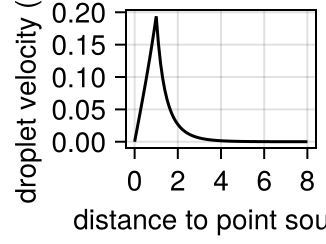

In [15]:
prl_col_size_double = 17.2 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1/3, prl_col_size_double*pt_per_cm*1/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax1 = Axis(fig[1, 1],xlabel="distance to point source",ylabel="droplet velocity (3D)")
x = 0:0.1:8
lines!(ax1, x, velocity3d.(x),color="black")
save("./figures/3dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

In [16]:
function piecewise(r)
    R = 1; χ = -1; Mc = 1; kp = 1; cm = 1; cp = 2; l = 1
    if r<l
        return exp(-(r+R)/l)*l*(l+r+exp(2*r/l)*(-l+r))*(l+R)/r^2
    else
        return exp(-(r+R)/l)*l*(l+r)*(l+R+exp(2*R/l)*(-l+R))/r^2
    end
end

piecewise (generic function with 1 method)

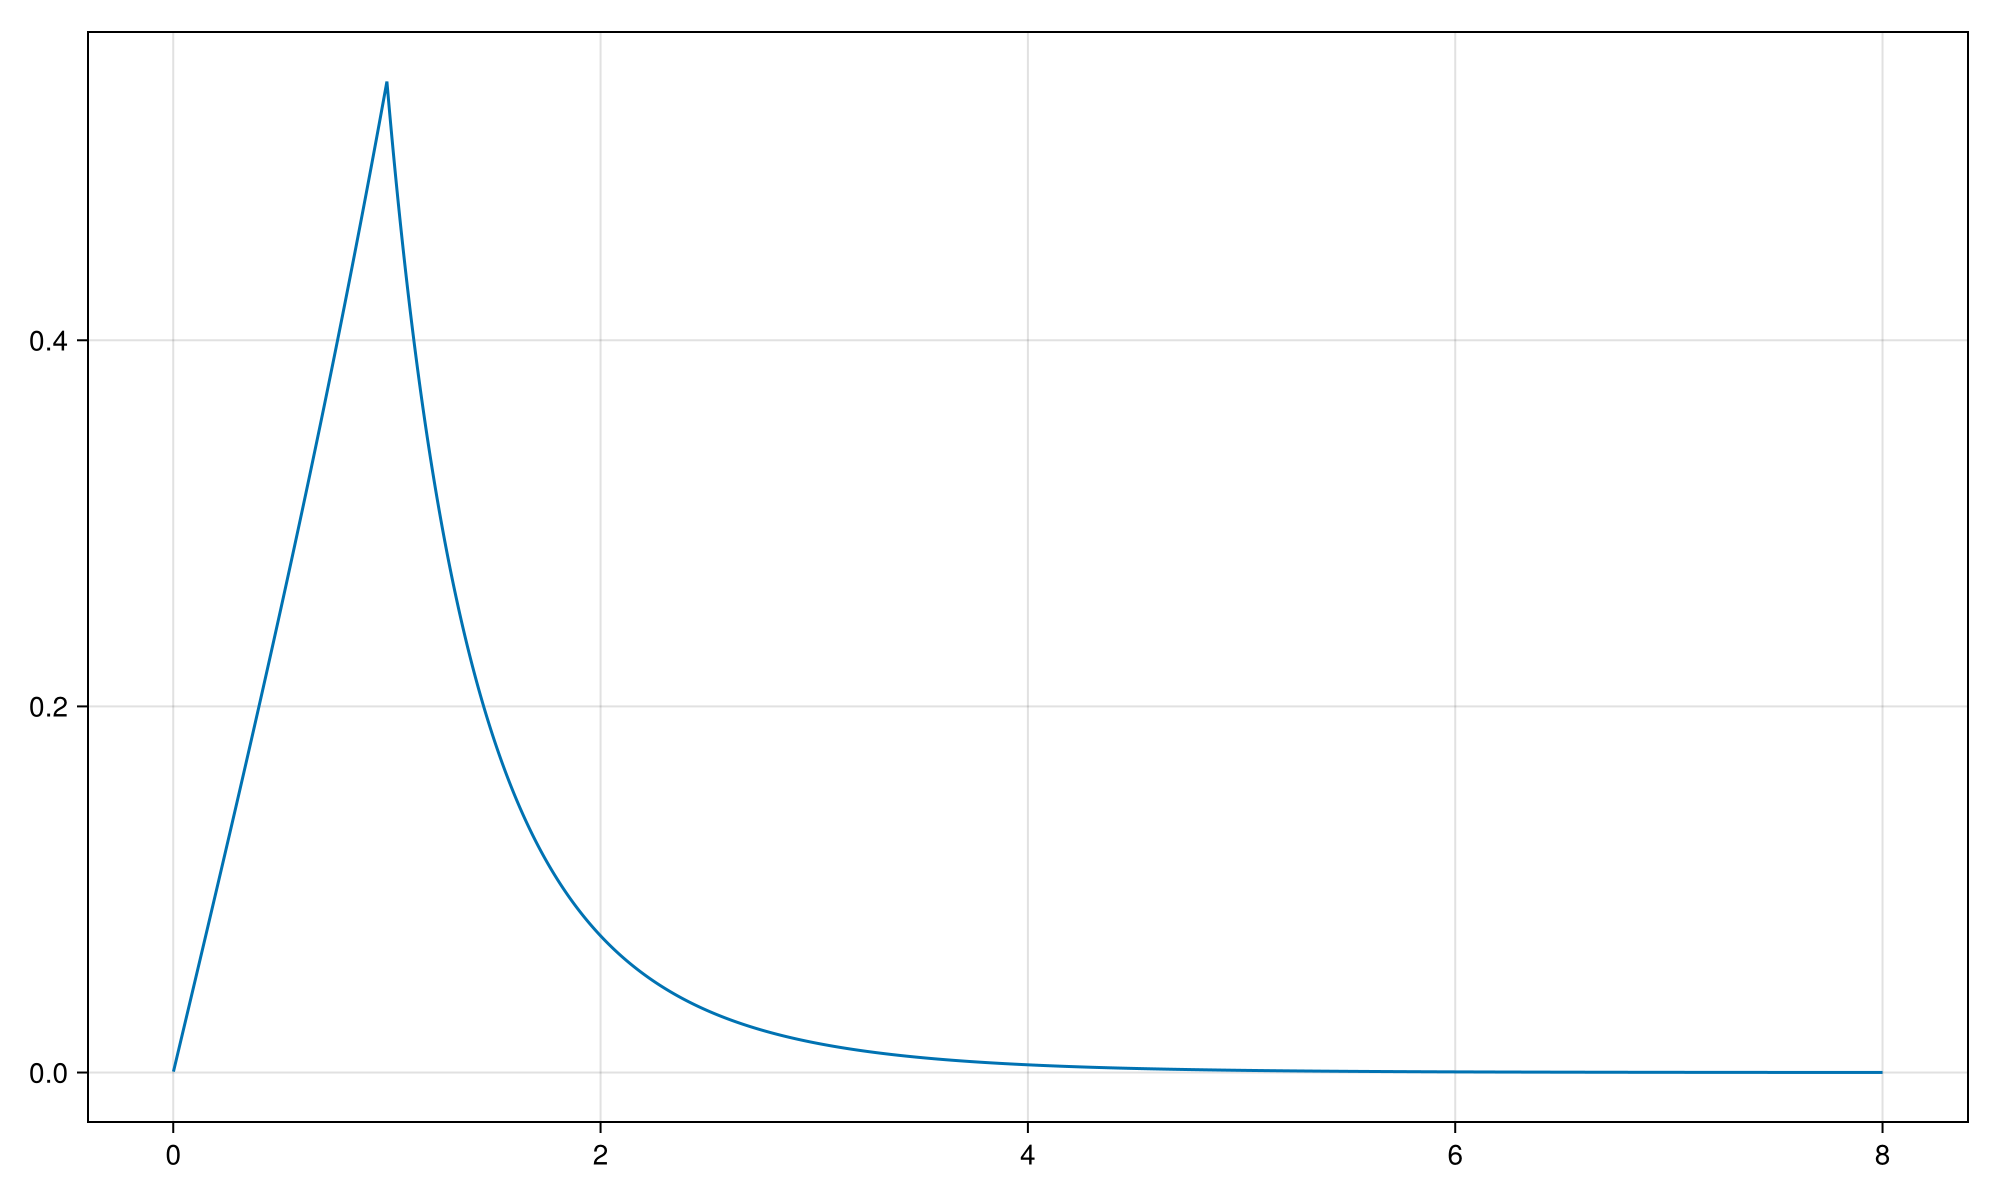

In [17]:
fig = Figure(size = (1000, 600))
ax1 = Axis(fig[1, 1])
x = 0:0.001:8
lines!(ax1, x, piecewise.(x))
fig

In [18]:
function energy(r, R, l)
    if r < R 
        return 2*exp(-R/l)*l*(l+R)*(-r+l*sinh(r/l))/r
    else
        return exp(-(r+R)/l)*l*(2*exp((r+R)/l)*l*r+exp(2*R/l)*l*(l-R)-(l+2*exp(r/l)*r)*(l+R))/r
    end
end

energy (generic function with 1 method)

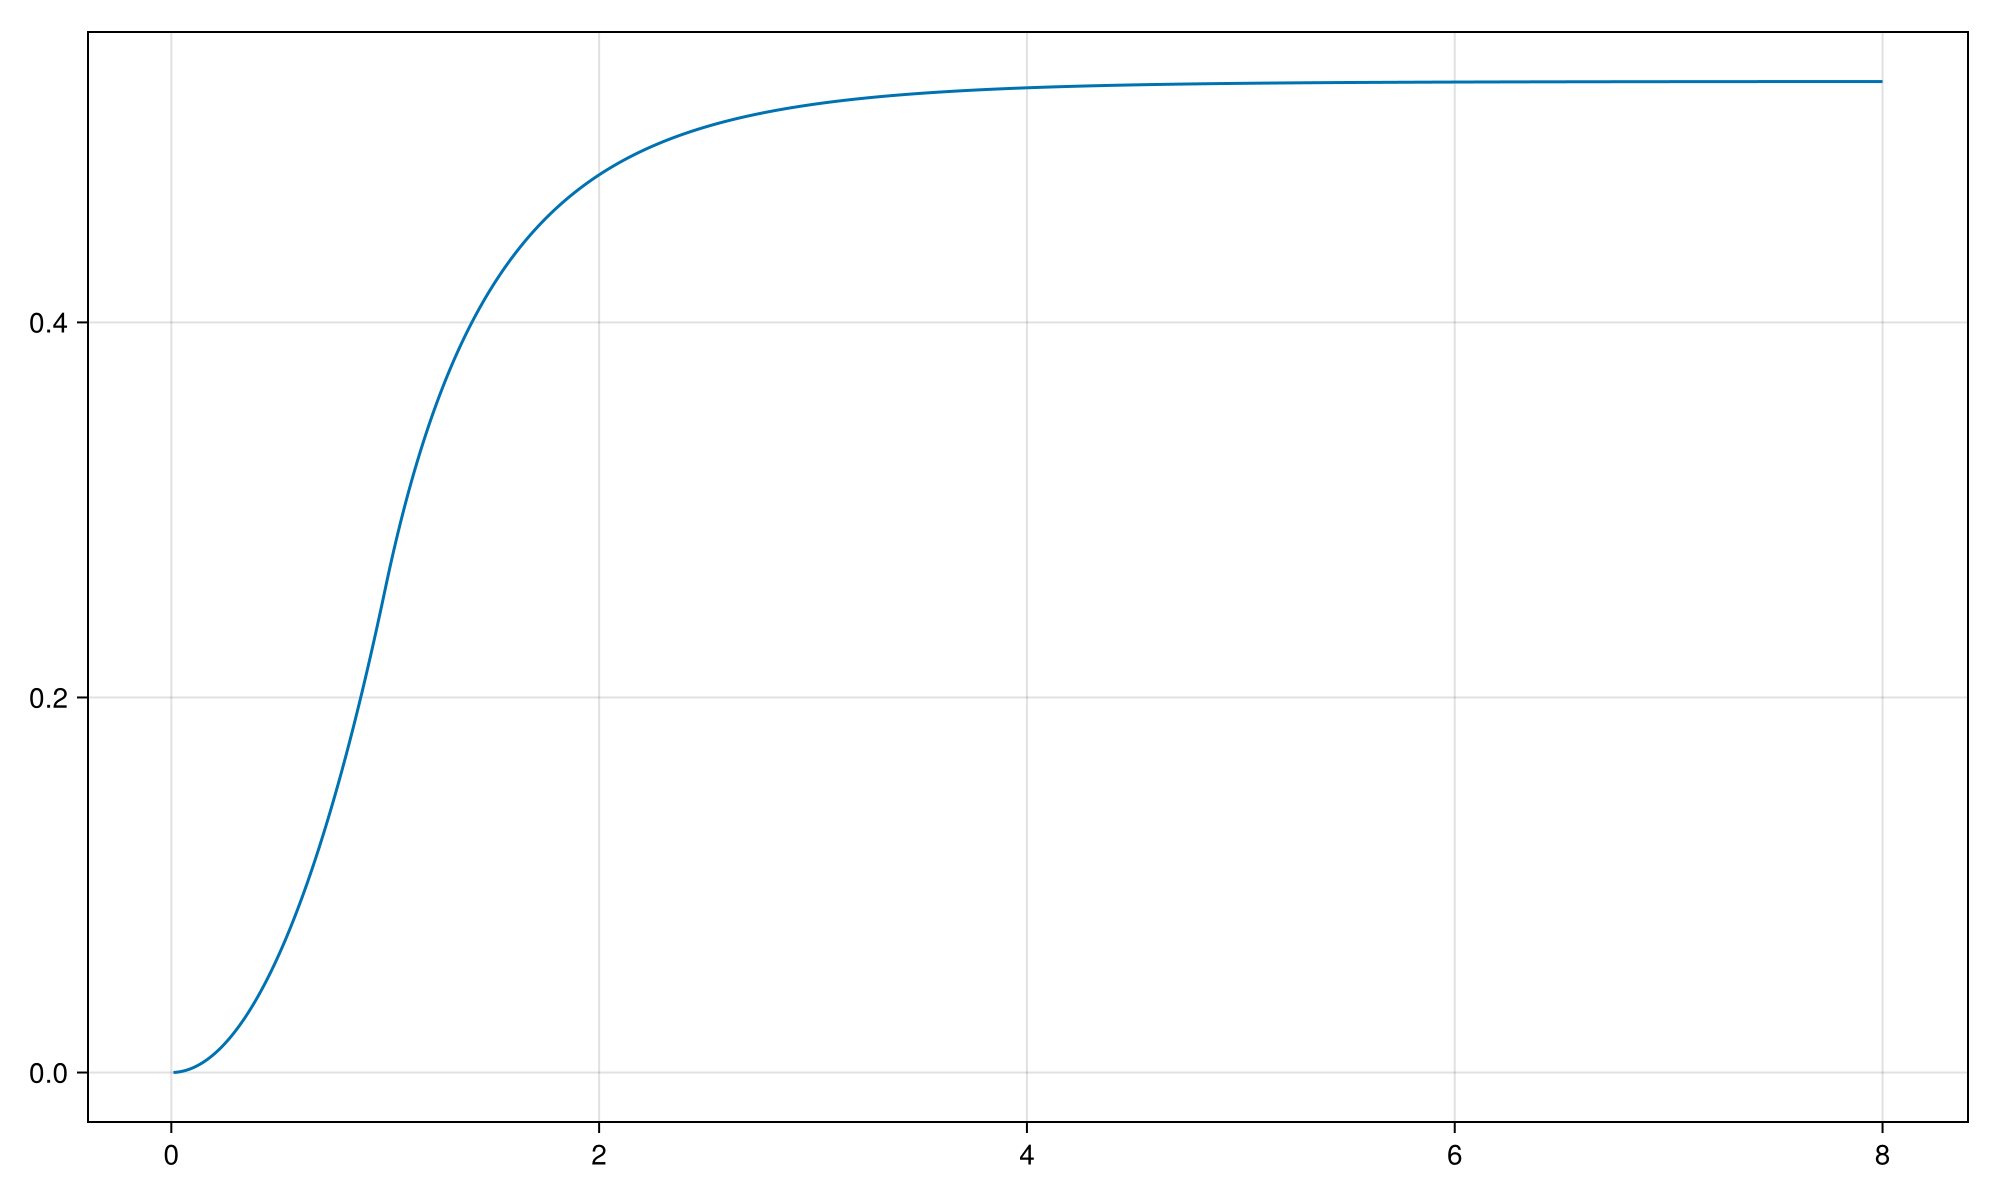

In [19]:
fig = Figure(size = (1000, 600))
ax1 = Axis(fig[1, 1])
r = 0:0.01:8
R = 1; l = 1
lines!(ax1, r, energy.(r,R,l))
fig

In [20]:
function epdistance(r,α,β,R,l)
    return 4*π*r^2*exp(-α*r^2-β*energy(r,R,l))
end
function maxwell(r,α)
    return 4*π*(α/π)^(3/2)*r^2*exp(-α*(r^2))
end

maxwell (generic function with 1 method)

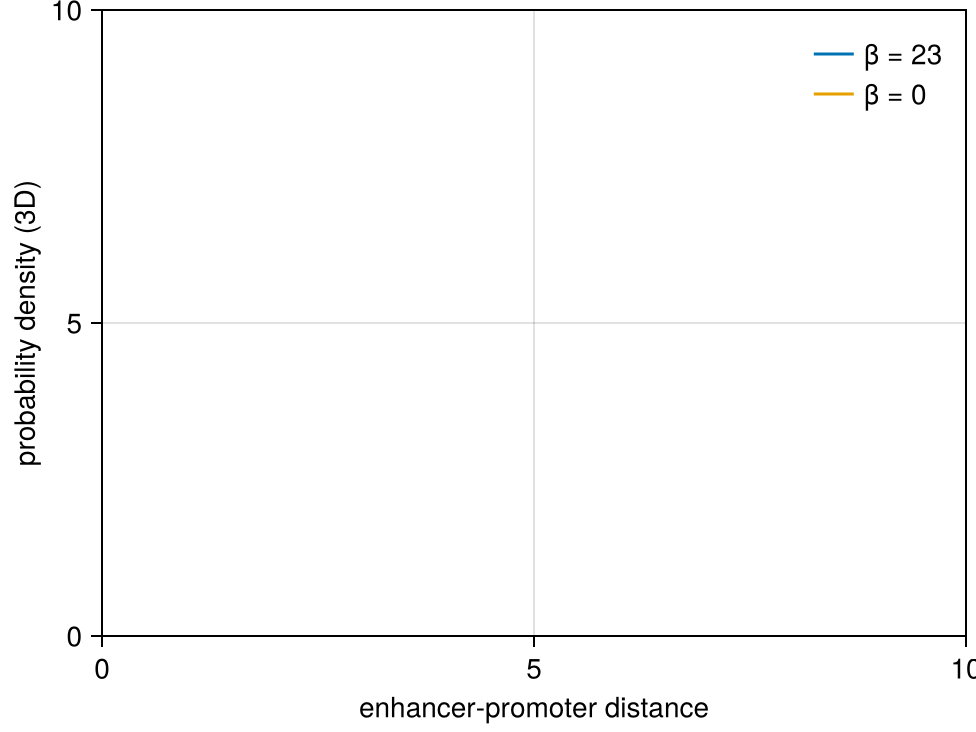

In [21]:
r = 0.01:0.01:6; α = 1; β = 100; R = 4; l = 1

function withflow(ax,β)
    function f(u,p)
        r = u[1]
        α = p[1]; β = p[2]; R = p[3]; l = p[4]
        return epdistance(r,α,β,R,l)
    end
    domain = ([0.], [Inf]); p = (α, β, R, l); prob = IntegralProblem(f, domain, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-9)
    prefactor = sol.u
    lines!(ax, r, epdistance.(r,α,β,R,l)/prefactor, label="β = $β")
end


prl_col_size_double = 17.2*3 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1/3, prl_col_size_double*pt_per_cm*1/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax1 = Axis(fig[1, 1],xlabel="enhancer-promoter distance",ylabel="probability density (3D)")
# withflow(ax1,100)
withflow(ax1,23)
# withflow(ax1,20)
withflow(ax1,0)


# lines!(ax1, r, maxwell.(r,α), label="Maxwell")
axislegend(ax1, framevisible = false, rowgap = 0)
# save("./figures/distribution.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

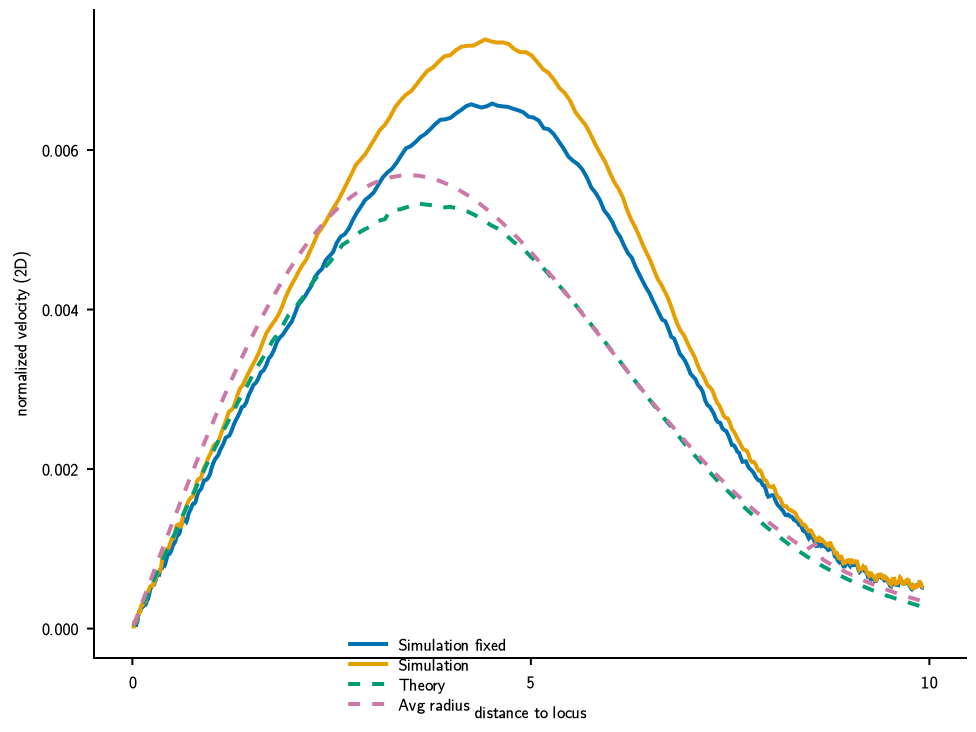

In [91]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase


prl_col_size_double = 17.2 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1, prl_col_size_double*pt_per_cm*3/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "distance to locus", ylabel = "normalized velocity (2D)")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation fixed")

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, linestyle = :dash, label="Theory")

# Fixed radius
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

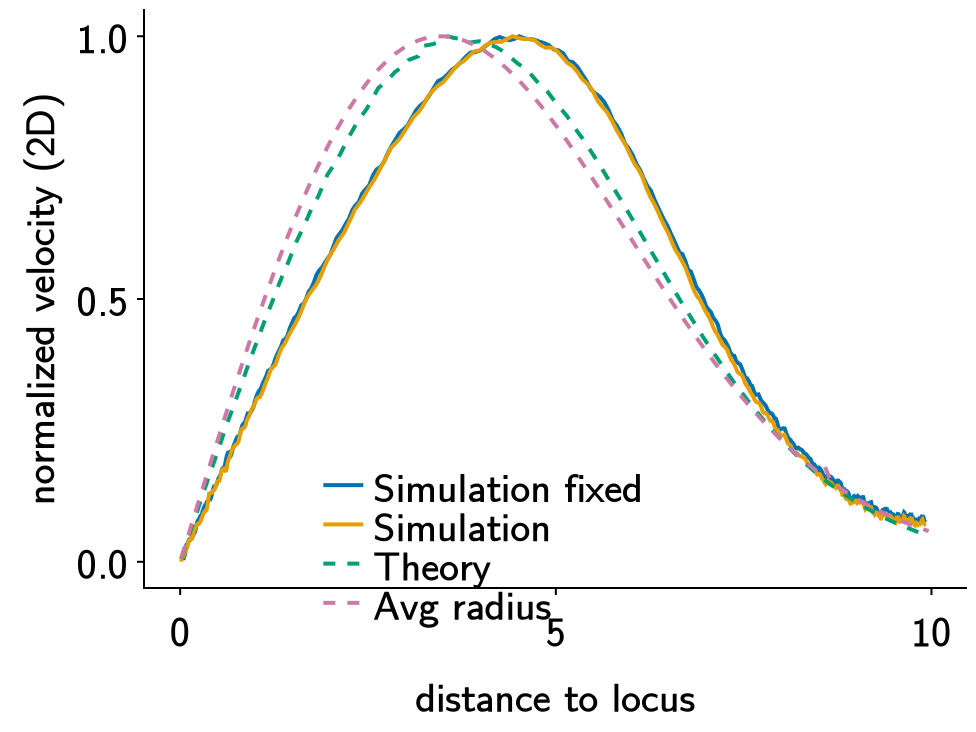

In [103]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase


prl_col_size_double = 17.2 # cm
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1, prl_col_size_double*pt_per_cm*3/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "distance to locus", ylabel = "normalized velocity (2D)")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity ./maximum(df.smoothed_velocity), label="Simulation fixed")

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity ./maximum(df.smoothed_velocity), label="Simulation")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity ./maximum(flow_stats_df.analytical_velocity), linestyle = :dash, label="Theory")

# Fixed radius
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR ./maximum(flow_stats_df.analytical_velocity_avgR), linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig